# **Predicting the perception of deprivation from VHR Satelite Images.**

# Intro

This code is developed by [**Taïs Grippa**](https://github.com/tgrippa) for the **PARTIMAP** project, based on the initial code of [**Eqi Luo**](https://github.com/EqiLuo/MappingDeprivation). 



# 0. Import libraries

Firstly, install and import the necessary libraries for this analysis.

In [1]:
import numpy as np
import os, sys
import pandas as pd
import glob
import re
from tensorflow import keras
import natsort
import sklearn
import tensorflow as tf
import datetime
import cv2
import shutil
import time
import tempfile
import h5py

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from osgeo import gdal
from osgeo import gdal_array
from natsort import natsorted
from keras.utils import np_utils
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras import backend as K

Check the version of Tensorflow. It should be 2.8.0

In [4]:
print(tf.__version__)

2.8.0


Check the output of nvidia-smi utility to monitor the GPU usage.

In [5]:
! nvidia-smi

Wed Feb 23 17:49:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 22%   38C    P0    54W / 250W |      0MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 10%   

Configure Tensorflow (v2.8) for deterministic behavior (to get reproducible results). See official manual [HERE](https://www.tensorflow.org/api_docs/python/tf/config/experimental/enable_op_determinism). NOTICE: Has never worked properly :/

In [6]:
import random as python_random
SEED = 101
np.random.seed(SEED)
python_random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

Import Keras Tuner for Hyperparameter tuning

In [7]:
import keras_tuner as kt
from keras_tuner import HyperModel

Setup Keras to work with Mixed Precision to speed up the learning process and reduce GPU memory required. More information [HERE](https://keras.io/api/mixed_precision/).

In [8]:
# Setup Keras Mixed Precision
tf.keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


Import custom functions

In [9]:
# Add local module to the path
src = os.path.abspath('../SRC')
if src not in sys.path:
    sys.path.append(src)

In [10]:
# Import functions for processing time information
from processing_time import start_processing, print_processing_time
# Import function that checks and creates folder
from mkdir import check_create_dir
# Import functions for plots
from plots import plot_loss, plot_pred_test, plot_pred_train
# Import functions for metrics to monitoring accuracy
from metrics import coeff_determination
# Import functions for display
from display import Norma_Xpercentile
# Import functions for exportation of results
from export_results import save_predictions, write_run_metrics_file

Test is GPU(s) is(are) available for processing and measure the speed-up of using it(them). 

In [50]:
%run ../SRC/Check_GPU_available.py

2 Physical GPUs, 2 Logical GPUs
Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
1.1111924250144511
GPU (s):
0.033756389981135726
GPU speedup over CPU: 32x


# 1. Data preparation 

**In this part, we load the data prepared before**

In [51]:
# Define working path 
root = "/home/tgrippa/PARTIMAP_processing"
output_path = os.path.join(root, "output")
data_path = os.path.join(output_path, "data")
model_path = os.path.join(output_path, "model")
results_path = os.path.join(output_path, "results")

In [52]:
#Check and create output data directory if needed
list_directories = [output_path, model_path, results_path, data_path]
for path in list_directories:
    check_create_dir(path)  

The folder '/home/tgrippa/PARTIMAP_processing/output' already exists
The folder '/home/tgrippa/PARTIMAP_processing/output/model' already exists
The folder '/home/tgrippa/PARTIMAP_processing/output/results' already exists
The folder '/home/tgrippa/PARTIMAP_processing/output/data' already exists


In [53]:
with h5py.File(os.path.join(data_path,"VNIR_128.hdf5"), mode="r") as f:
    x_train = np.asarray(f["x_train"])
    x_test = np.asarray(f["x_test"])
    y_train = np.asarray(f["y_train"])
    y_test = np.asarray(f["y_test"])
    train_ID = np.asarray(f["train_ID"])
    test_ID = np.asarray(f["test_ID"])

# 2. Definition of several functions for the model

## 2.1 Data augmentation layers

#### **Data augmentation definition**

In [56]:
# Define data augmentation to be included at the top of the sequential model 
data_augmentation = tf.keras.Sequential([
                        layers.RandomFlip("vertical"),
                        layers.RandomRotation(0.2, fill_mode='reflect'),
                        layers.RandomTranslation(height_factor=0.05, width_factor=0.05, fill_mode='reflect'),
                    ])

# 3 Model training
In this part, we build a VGG-like model to predict the deprivation degree. We fine-tune the model's hyperparameter in different stages. 

## 3.1 Hyperparameters tuning
In this part, we build a VGG-like model to predict the deprivation degree. We fine-tune the model's hyperparameter in different stages. 

### 3.1.1 HP: Conv filters + FC nodes

After running multiple times this HP tuning set, the best result is not always the same. But at least there is a progression in the number of filter for the convolutions layers. The number of nodes in the FC layers is consistent and equal to 256/256.

In [57]:
# Input shape 
#input_shape = (256, 256, 3)
input_shape = (128, 128, 4)
#input_shape = (64, 64, 3)

In [58]:
## VGG-like regression model with hyperparameter tuning

def VGG_model(hp):
    model = Sequential()
    
    # Data augmentation
    model.add(data_augmentation)
    
    # block 1 
    hp_filters_blk1 = hp.Choice("hp_filters_blk1", [32,64]) #Hyperparameter tuning
    model.add(Conv2D(hp_filters_blk1, (3, 3), padding='same', name='block1_conv1', input_shape=input_shape)) #block1_conv1
    model.add(BatchNormalization(axis=-1, name='block1_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk1, (3, 3), padding='same', name='block1_conv2')) #block1_conv2 
    model.add(BatchNormalization(axis=-1, name='block1_bn2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block1_pool')) #block1_pool
    
    # block 2 
    hp_filters_blk2 = hp.Choice("hp_filters_blk2", [32,64,128]) #Hyperparameter tuning
    model.add(Conv2D(hp_filters_blk2, (3, 3), padding='same', name='block2_conv1')) #block2_conv1
    model.add(BatchNormalization(axis=-1, name='block2_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk2, (3, 3), padding='same', name='block2_conv2')) #block2_conv2
    model.add(BatchNormalization(axis=-1, name='block2_bn2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block2_pool')) #block2_pool
    
    # block 3 
    hp_filters_blk3 = hp.Choice("hp_filters_blk3", [128,256]) #Hyperparameter tuning
    model.add(Conv2D(hp_filters_blk3, (3, 3), padding='same', name='block3_conv1')) #block3_conv1
    model.add(BatchNormalization(axis=-1, name = 'block3_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk3, (3, 3), padding='same', name='block3_conv2')) #block3_conv2
    model.add(BatchNormalization(axis=-1, name='block3_bn2'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk3, (3, 3), padding='same', name='block3_conv3')) #block3_conv3
    model.add(BatchNormalization(axis=-1, name='block3_bn3'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block3_pool')) #block3_pool

    # Now to configure the fully conneceted layers 
    
    # FC1
    model.add(Flatten())
    hp_filters_FC1 = hp.Choice("hp_filters_FC1", [128,256]) #Hyperparameter tuning
    model.add(Dense(hp_filters_FC1, name = 'fc1'))
    model.add(BatchNormalization(axis=-1, name = 'fc1_bn1'))
    model.add(Activation('relu'))
    model.add(Dropout(0.1, name = 'fc1_drop1', seed=3)) 
    
    # FC2
    hp_filters_FC2 = hp.Choice("hp_filters_FC2", [128,256]) #Hyperparameter tuning
    model.add(Dense(hp_filters_FC2, name = 'fc2'))
    model.add(BatchNormalization(axis=-1, name = 'fc2_bn1'))
    model.add(Activation('relu'))
    model.add(Dropout(0.1, name = 'fc2_drop1', seed=3))
    
    # Regression layer 
    model.add(Dense(1, activation = 'linear', name = 'regression'))   
    
    # Optimizer with Keras Tuner on learning rate    
    opt = Adam(learning_rate=1e-3)
    
    # Compile the model with LOSS, Optimizer, metrics
    model.compile(loss="mean_squared_error", optimizer=opt, metrics=['mean_absolute_error','RootMeanSquaredError',coeff_determination]) 
   
    return model

In [59]:
# Check if the Hyperparameter model works fine
VGG_model(kt.HyperParameters())

In [ ]:
# Keras Tuner with Hyperband
tuner = kt.Hyperband(
    hypermodel=VGG_model,
    #objective=kt.Objective("val_loss", direction="min"),
    objective=kt.Objective("val_coeff_determination", direction="max"),
    max_epochs=50,
    factor=3,
    hyperband_iterations=1,
    seed=SEED,
    overwrite=True,
    directory=os.path.join(model_path,"Tuner"),
    project_name="Partimap_HpTuning_A",
)

In [ ]:
# Search space summary
tuner.search_space_summary()

In [ ]:
## Define CALLBACKS
# Using checkpoint callback fucntion to save the weights that yield the best result on validation dataset. 
checkpoint_filepath = os.path.join(tempfile.mkdtemp(),'Best_performed_model.hdf5')
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')
# Using 'Reduce LR on Plateau' function to let the model take smaller steps when the loss value hold on, and eventually maybe found a better optima.
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, mode='auto', cooldown=0, min_lr=0)
# Using "Early stopping" function to stop the training when 
early = EarlyStopping(monitor="val_loss",mode="min",patience=20) # probably needs to be more patient, but kaggle time is limited

## HP SEARCH
# Save current time for time management
starttime = start_processing()
# Define batch size and number of epoch to train
BSIZE = 64
NB_EPOCHS = 30
# Perform the HP search
tuner.search(x_train, y_train, 
             batch_size=BSIZE, 
             epochs=NB_EPOCHS, 
             validation_data=(x_test,y_test),
             callbacks=[early])
## Print processing time
print_processing_time(starttime ,"Process achieved in ")

In [ ]:
# Summary of the HP tuning
tuner.results_summary(num_trials=7)

In [16]:
# Print best hyperparameters for tuning A
best_hp_A = {'hp_filters_blk1': 32,
 'hp_filters_blk2': 64,
 'hp_filters_blk3': 256,
 'hp_filters_FC1': 128,
 'hp_filters_FC2': 256,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '33329bc3ab0971756d77bb78ec740f4f'}

### 3.1.2 HP: Network depth (Block 4)

The preivous stage of hyperparameter tuning showed no tendancy to overfitting. So, Dropout rate after FC1 ans FC2 has been maintained at its previous value 0.1 and will not be optimized. 

Here, we use the RandomSearch algorithm instead of the Hyperband algorithm since we don't test much values.     

In [145]:
# Input shape 
#input_shape = (256, 256, 3)
input_shape = (128, 128, 4)
#input_shape = (64, 64, 3)

In [146]:
## VGG-like regression model with hyperparameter tuning

def VGG_model(hp):
    model = Sequential()
    
    # Data augmentation
    model.add(data_augmentation)
    
    # block 1 
    hp_filters_blk1 = best_hp_A['hp_filters_blk1'] #Value found after previous Hyperparameter tuning
    model.add(Conv2D(hp_filters_blk1, (3, 3), padding='same', name='block1_conv1', input_shape=input_shape)) #block1_conv1
    model.add(BatchNormalization(axis=-1, name='block1_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk1, (3, 3), padding='same', name='block1_conv2')) #block1_conv2 
    model.add(BatchNormalization(axis=-1, name='block1_bn2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block1_pool')) #block1_pool
    
    # block 2 
    hp_filters_blk2 = best_hp_A['hp_filters_blk2'] #Value found after previous Hyperparameter tuning
    model.add(Conv2D(hp_filters_blk2, (3, 3), padding='same', name='block2_conv1')) #block2_conv1
    model.add(BatchNormalization(axis=-1, name='block2_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk2, (3, 3), padding='same', name='block2_conv2')) #block2_conv2
    model.add(BatchNormalization(axis=-1, name='block2_bn2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block2_pool')) #block2_pool
    
    # block 3 
    hp_filters_blk3 = best_hp_A['hp_filters_blk3'] #Value found after previous Hyperparameter tuning
    model.add(Conv2D(hp_filters_blk3, (3, 3), padding='same', name='block3_conv1')) #block3_conv1
    model.add(BatchNormalization(axis=-1, name = 'block3_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk3, (3, 3), padding='same', name='block3_conv2')) #block3_conv2
    model.add(BatchNormalization(axis=-1, name='block3_bn2'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk3, (3, 3), padding='same', name='block3_conv3')) #block3_conv3
    model.add(BatchNormalization(axis=-1, name='block3_bn3'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block3_pool')) #block3_pool
    
    # block 4 
    hp_bool_blk4 = hp.Boolean('hp_bool_blk4', default=True) #Hyperparameter tuning
    if hp_bool_blk4:
        hp_filters_blk4 = hp.Choice("filters_blk4", [128,256,512], parent_name='hp_bool_blk4', parent_values=True) #Hyperparameter tuning
        model.add(Conv2D(hp_filters_blk4, (3, 3), padding='same', name='block4_conv1')) #block4_conv1
        model.add(BatchNormalization(axis=-1, name='block4_bn1'))
        model.add(Activation('relu'))
        model.add(Conv2D(hp_filters_blk4, (3, 3), padding='same', name='block4_conv2')) #block4_conv2
        model.add(BatchNormalization(axis=-1, name='block4_bn2'))
        model.add(Activation('relu'))
        model.add(Conv2D(hp_filters_blk4, (3, 3), padding='same', name='block4_conv3')) #block4_conv3
        model.add(BatchNormalization(axis=-1, name='block4_bn3'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), name='block4_pool')) #block4_pool   
    
    # Now to configure the fully conneceted layers 
    
    # FC1
    model.add(Flatten())
    hp_filters_FC1 = best_hp_A['hp_filters_FC1'] #Value found after previous Hyperparameter tuning
    model.add(Dense(hp_filters_FC1, name = 'fc1'))
    model.add(BatchNormalization(axis=-1, name = 'fc1_bn1'))
    model.add(Activation('relu'))
    model.add(Dropout(0.1, name = 'fc1_drop1', seed=3)) 
    
    # FC2
    hp_filters_FC2 = best_hp_A['hp_filters_FC2'] #Value found after previous Hyperparameter tuning
    model.add(Dense(hp_filters_FC2, name = 'fc2'))
    model.add(BatchNormalization(axis=-1, name = 'fc2_bn1'))
    model.add(Activation('relu'))
    model.add(Dropout(0.1, name = 'fc2_drop1', seed=3))

    # Regression layer 
    model.add(Dense(1, activation = 'linear', name = 'regression'))   
    
    # Optimizer with Keras Tuner on learning rate    
    opt = Adam(learning_rate=1e-3)
    
    # Compile the model with LOSS, Optimizer, metrics
    model.compile(loss="mean_squared_error", optimizer=opt, metrics=['mean_absolute_error','RootMeanSquaredError',coeff_determination]) 
   
    return model

In [147]:
# Check if the Hyperparameter model works fine
VGG_model(kt.HyperParameters())

In [ ]:
# Keras Tuner with RandomSearch
tuner = kt.RandomSearch(
    hypermodel=VGG_model,
    #objective=kt.Objective("val_loss", direction="min"),
    objective=kt.Objective("val_coeff_determination", direction="max"),
    max_trials=10, #Maximum number of HP combination to test
    executions_per_trial=3, #Number of execution of the same HP combination
    overwrite=True,
    directory=os.path.join(model_path,"Tuner"),
    project_name="Partimap_HpTuning_B",
)

In [ ]:
# Search space summary
tuner.search_space_summary()

In [ ]:
## Define CALLBACKS
# Using checkpoint callback fucntion to save the weights that yield the best result on validation dataset. 
checkpoint_filepath = os.path.join(tempfile.mkdtemp(),'Best_performed_model.hdf5')
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')
# Using 'Reduce LR on Plateau' function to let the model take smaller steps when the loss value hold on, and eventually maybe found a better optima.
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, mode='auto', cooldown=0, min_lr=0)
# Using "Early stopping" function to stop the training when 
early = EarlyStopping(monitor="val_loss",mode="min",patience=20) # probably needs to be more patient, but kaggle time is limited

## HP SEARCH
# Save current time for time management
starttime = start_processing()
# Define batch size and number of epoch to train
BSIZE = 64
NB_EPOCHS = 50
# Perform the HP search
tuner.search(x_train, y_train, 
             batch_size=BSIZE, 
             epochs=NB_EPOCHS, 
             validation_data=(x_test,y_test),
             callbacks=[early])
## Print processing time
print_processing_time(starttime ,"Process achieved in ")

In [ ]:
# Summary of the HP tuning
tuner.results_summary(num_trials=3)

In [17]:
# Print best hyperparameters
best_hp_B = {'hp_bool_blk4': False}

### 3.1.3 HP: Learning rate for Adam 

In [18]:
# Input shape 
#input_shape = (256, 256, 3)
input_shape = (128, 128, 4)
#input_shape = (64, 64, 3)

In [19]:
## VGG-like regression model with hyperparameter tuning

def VGG_model(hp):
    model = Sequential()
    
    # Data augmentation
    model.add(data_augmentation)
    
    # block 1 
    hp_filters_blk1 = best_hp_A['hp_filters_blk1'] #Value found after previous Hyperparameter tuning
    model.add(Conv2D(hp_filters_blk1, (3, 3), padding='same', name='block1_conv1', input_shape=input_shape)) #block1_conv1
    model.add(BatchNormalization(axis=-1, name='block1_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk1, (3, 3), padding='same', name='block1_conv2')) #block1_conv2 
    model.add(BatchNormalization(axis=-1, name='block1_bn2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block1_pool')) #block1_pool
    
    # block 2 
    hp_filters_blk2 = best_hp_A['hp_filters_blk2'] #Value found after previous Hyperparameter tuning
    model.add(Conv2D(hp_filters_blk2, (3, 3), padding='same', name='block2_conv1')) #block2_conv1
    model.add(BatchNormalization(axis=-1, name='block2_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk2, (3, 3), padding='same', name='block2_conv2')) #block2_conv2
    model.add(BatchNormalization(axis=-1, name='block2_bn2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block2_pool')) #block2_pool
    
    # block 3 
    hp_filters_blk3 = best_hp_A['hp_filters_blk3'] #Value found after previous Hyperparameter tuning
    model.add(Conv2D(hp_filters_blk3, (3, 3), padding='same', name='block3_conv1')) #block3_conv1
    model.add(BatchNormalization(axis=-1, name = 'block3_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk3, (3, 3), padding='same', name='block3_conv2')) #block3_conv2
    model.add(BatchNormalization(axis=-1, name='block3_bn2'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk3, (3, 3), padding='same', name='block3_conv3')) #block3_conv3
    model.add(BatchNormalization(axis=-1, name='block3_bn3'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block3_pool')) #block3_pool
    
    # block 4 
    hp_bool_blk4 = best_hp_B['hp_bool_blk4'] #Value found after previous Hyperparameter tuning
    if hp_bool_blk4:
        hp_filters_blk4 = best_hp_B['hp_filters_blk4'] #Value found after previous Hyperparameter tuning
        model.add(Conv2D(hp_filters_blk4, (3, 3), padding='same', name='block4_conv1')) #block4_conv1
        model.add(BatchNormalization(axis=-1, name='block4_bn1'))
        model.add(Activation('relu'))
        model.add(Conv2D(hp_filters_blk4, (3, 3), padding='same', name='block4_conv2')) #block4_conv2
        model.add(BatchNormalization(axis=-1, name='block4_bn2'))
        model.add(Activation('relu'))
        model.add(Conv2D(hp_filters_blk4, (3, 3), padding='same', name='block4_conv3')) #block4_conv3
        model.add(BatchNormalization(axis=-1, name='block4_bn3'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), name='block4_pool')) #block4_pool   
    
    # Now to configure the fully conneceted layers 
    
    # FC1
    model.add(Flatten())
    hp_filters_FC1 = best_hp_A['hp_filters_FC1'] #Value found after previous Hyperparameter tuning
    model.add(Dense(hp_filters_FC1, name = 'fc1'))
    model.add(BatchNormalization(axis=-1, name = 'fc1_bn1'))
    model.add(Activation('relu'))
    model.add(Dropout(0.1, name = 'fc1_drop1', seed=3)) 
    
    # FC2
    hp_filters_FC2 = best_hp_A['hp_filters_FC2'] #Value found after previous Hyperparameter tuning
    model.add(Dense(hp_filters_FC2, name = 'fc2'))
    model.add(BatchNormalization(axis=-1, name = 'fc2_bn1'))
    model.add(Activation('relu'))
    model.add(Dropout(0.1, name = 'fc2_drop1', seed=3))

    # Regression layer 
    model.add(Dense(1, activation = 'linear', name = 'regression'))   
    
    # Optimizer with Keras Tuner on learning rate    
    hp_lr = hp.Float("hp_lr", min_value=1e-4, max_value=1e-1, sampling="log")
    opt = Adam(learning_rate=hp_lr)
    
    # Compile the model with LOSS, Optimizer, metrics
    model.compile(loss="mean_squared_error", optimizer=opt, metrics=['mean_absolute_error','RootMeanSquaredError',coeff_determination]) 
   
    return model

In [151]:
# Check if the Hyperparameter model works fine
VGG_model(kt.HyperParameters())

In [152]:
# Keras Tuner with RandomSearch
tuner = kt.RandomSearch(
    hypermodel=VGG_model,
    #objective=kt.Objective("val_loss", direction="min"),
    objective=kt.Objective("val_coeff_determination", direction="max"),
    max_trials=7, #Maximum number of HP combination to test
    executions_per_trial=1, #Number of execution of the same HP combination
    overwrite=True,
    directory=os.path.join(model_path,"Tuner"),
    project_name="Partimap_HpTuning_C",
)

In [153]:
# Search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 1
hp_lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [154]:
## Define CALLBACKS
# Using checkpoint callback fucntion to save the weights that yield the best result on validation dataset. 
checkpoint_filepath = os.path.join(tempfile.mkdtemp(),'Best_performed_model.hdf5')
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')
# Using 'Reduce LR on Plateau' function to let the model take smaller steps when the loss value hold on, and eventually maybe found a better optima.
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, mode='auto', cooldown=0, min_lr=0)
# Using "Early stopping" function to stop the training when 
early = EarlyStopping(monitor="val_loss",mode="min",patience=20) # probably needs to be more patient, but kaggle time is limited

## HP SEARCH
# Save current time for time management
starttime = start_processing()
# Define batch size and number of epoch to train
BSIZE = 64
NB_EPOCHS = 100
# Perform the HP search
tuner.search(x_train, y_train, 
             batch_size=BSIZE, 
             epochs=NB_EPOCHS, 
             validation_data=(x_test,y_test),
             callbacks=[early])
## Print processing time
print_processing_time(starttime ,"Process achieved in ")

Trial 7 Complete [00h 03m 25s]
val_coeff_determination: -0.038070544600486755

Best val_coeff_determination So Far: 0.25908514857292175
Total elapsed time: 00h 24m 10s
INFO:tensorflow:Oracle triggered exit


'Process achieved in 24 minutes and 10.6 seconds'

In [155]:
# Summary of the HP tuning
tuner.results_summary(num_trials=3)

Results summary
Results in /home/partimap/PARTIMAP_processing/output/model/Tuner/Partimap_HpTuning_C
Showing 3 best trials
Objective(name='val_coeff_determination', direction='max')
Trial summary
Hyperparameters:
hp_lr: 0.00023988977253075727
Score: 0.25908514857292175
Trial summary
Hyperparameters:
hp_lr: 0.09615816568610903
Score: nan
Trial summary
Hyperparameters:
hp_lr: 0.003438825606861328
Score: 0.307555228471756


In [20]:
# Print best hyperparameters
best_hp_C = {'hp_lr': 0.00023988977253075727}

In [159]:
# Get the best model with restored weights from the best checkpoint (at the end of the best epoch of best trial). 
best_model = tuner.get_best_models(1)[0]
# Print the best model summary
best_model.build(x_test.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 4)       0         
                                                                 
 block1_conv1 (Conv2D)       (199, 128, 128, 32)       1184      
                                                                 
 block1_bn1 (BatchNormalizat  (199, 128, 128, 32)      128       
 ion)                                                            
                                                                 
 activation (Activation)     (199, 128, 128, 32)       0         
                                                                 
 block1_conv2 (Conv2D)       (199, 128, 128, 32)       9248      
                                                                 
 block1_bn2 (BatchNormalizat  (199, 128, 128, 32)      128       
 ion)                                                   

# 4 Run multiple time the model with best hyperparameters 

In [21]:
## VGG-like regression model with hyperparameter tuning

def VGG_model(hp):
    model = Sequential()
    
    # Data augmentation
    model.add(data_augmentation)
    
    # block 1 
    hp_filters_blk1 = best_hp_A['hp_filters_blk1'] #Value found after previous Hyperparameter tuning
    model.add(Conv2D(hp_filters_blk1, (3, 3), padding='same', name='block1_conv1', input_shape=input_shape)) #block1_conv1
    model.add(BatchNormalization(axis=-1, name='block1_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk1, (3, 3), padding='same', name='block1_conv2')) #block1_conv2 
    model.add(BatchNormalization(axis=-1, name='block1_bn2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block1_pool')) #block1_pool
    
    # block 2 
    hp_filters_blk2 = best_hp_A['hp_filters_blk2'] #Value found after previous Hyperparameter tuning
    model.add(Conv2D(hp_filters_blk2, (3, 3), padding='same', name='block2_conv1')) #block2_conv1
    model.add(BatchNormalization(axis=-1, name='block2_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk2, (3, 3), padding='same', name='block2_conv2')) #block2_conv2
    model.add(BatchNormalization(axis=-1, name='block2_bn2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block2_pool')) #block2_pool
    
    # block 3 
    hp_filters_blk3 = best_hp_A['hp_filters_blk3'] #Value found after previous Hyperparameter tuning
    model.add(Conv2D(hp_filters_blk3, (3, 3), padding='same', name='block3_conv1')) #block3_conv1
    model.add(BatchNormalization(axis=-1, name = 'block3_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk3, (3, 3), padding='same', name='block3_conv2')) #block3_conv2
    model.add(BatchNormalization(axis=-1, name='block3_bn2'))
    model.add(Activation('relu'))
    model.add(Conv2D(hp_filters_blk3, (3, 3), padding='same', name='block3_conv3')) #block3_conv3
    model.add(BatchNormalization(axis=-1, name='block3_bn3'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block3_pool')) #block3_pool
    
    # block 4 
    hp_bool_blk4 = best_hp_B['hp_bool_blk4'] #Value found after previous Hyperparameter tuning
    if hp_bool_blk4:
        hp_filters_blk4 = best_hp_B['hp_filters_blk4'] #Value found after previous Hyperparameter tuning
        model.add(Conv2D(hp_filters_blk4, (3, 3), padding='same', name='block4_conv1')) #block4_conv1
        model.add(BatchNormalization(axis=-1, name='block4_bn1'))
        model.add(Activation('relu'))
        model.add(Conv2D(hp_filters_blk4, (3, 3), padding='same', name='block4_conv2')) #block4_conv2
        model.add(BatchNormalization(axis=-1, name='block4_bn2'))
        model.add(Activation('relu'))
        model.add(Conv2D(hp_filters_blk4, (3, 3), padding='same', name='block4_conv3')) #block4_conv3
        model.add(BatchNormalization(axis=-1, name='block4_bn3'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), name='block4_pool')) #block4_pool   
    
    # Now to configure the fully conneceted layers 
    
    # FC1
    model.add(Flatten())
    hp_filters_FC1 = best_hp_A['hp_filters_FC1'] #Value found after previous Hyperparameter tuning
    model.add(Dense(hp_filters_FC1, name = 'fc1'))
    model.add(BatchNormalization(axis=-1, name = 'fc1_bn1'))
    model.add(Activation('relu'))
    model.add(Dropout(0.1, name = 'fc1_drop1', seed=3)) 
    
    # FC2
    hp_filters_FC2 = best_hp_A['hp_filters_FC2'] #Value found after previous Hyperparameter tuning
    model.add(Dense(hp_filters_FC2, name = 'fc2'))
    model.add(BatchNormalization(axis=-1, name = 'fc2_bn1'))
    model.add(Activation('relu'))
    model.add(Dropout(0.1, name = 'fc2_drop1', seed=3))

    # Regression layer 
    model.add(Dense(1, activation = 'linear', name = 'regression'))   
    
    # Optimizer with Keras Tuner on learning rate    
    hp_lr = best_hp_C['hp_lr']
    opt = Adam(learning_rate=hp_lr)
    
    # Compile the model with LOSS, Optimizer, metrics
    model.compile(loss="mean_squared_error", optimizer=opt, metrics=['mean_absolute_error','RootMeanSquaredError',coeff_determination]) 
   
    return model

In [24]:
class mutli_run():
    
    def __init__(self, nbrun, earlypatience, modelHP, bsize, nb_epochs, datagen, outputfolder):
        self.nbrun = nbrun
        self.earlypatience = earlypatience
        self.modelHP = modelHP
        self.bsize = bsize
        self.nb_epochs = nb_epochs
        self.datagen = datagen
        self.outputfolder = outputfolder

    def run(self):        
        # Save current time for time management
        starttime = start_processing()
        # Create folder for the multirun 
        check_create_dir(self.outputfolder)
        # Create a table (pandas dataframe) to store the multiple run values
        mutlirun_table = pd.DataFrame(columns = ["Run", "Run_dir", "Weight_file", "RunTime", "Epochs", "R2_train", "rmse_train", "mae_train", "R2_test", "rmse_test", "mae_test"],dtype=object)
        # Create a list of history
        multirun_histories = []
        self.multirun_histories = multirun_histories
        for i in range(1,self.nbrun+1):    
            print("Starting run {}...".format(i))
            # Save current time for time management
            starttime = time.time()
            # Create a new instance of the model
            model = VGG_model(self.modelHP)
            # Define callbacks for this run (needed to reinitialise at least the checkpoint from the previous run)
            checkpoint_filepath = os.path.join(tempfile.mkdtemp(),'Best_performed_model.hdf5')
            checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')
            reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, mode='auto', cooldown=0, min_lr=0)
            if self.earlypatience:
                early = EarlyStopping(monitor="val_loss",mode="min",patience=self.earlypatience) # probably needs to be more patient
            tmp_csv_path = os.path.join(tempfile.gettempdir(), "run_log.csv")
            csv_logger = tf.keras.callbacks.CSVLogger(tmp_csv_path, separator=";", append=True)
            callbacklist = [checkpoint, csv_logger]
            if self.earlypatience:
                callbacklist.append(early)
        
            # Train the model 
            history = model.fit(self.datagen.flow(x_train, y_train, batch_size=self.bsize, shuffle=False, seed=3),
                                steps_per_epoch=int(len(x_train)/self.bsize),
                                validation_data = (x_test,y_test),
                                epochs = self.nb_epochs, 
                                callbacks = callbacklist
                                )
            # Save processing time
            training_time = round((time.time() - starttime)/60,1)
            
            # Append the run history to the multirun_hostories list
            multirun_histories.append(history)
            
            # Load the weights from the best checkpoint
            model.load_weights(checkpoint_filepath)
            # run the model on the train and test datasets 
            y_pred_test = model.predict(x_test) 
            y_pred_train = model.predict(x_train)

            # Calculate the R2 Score and RMSE
            R2_train = r2_score(y_train, y_pred_train)
            rmse_train = mean_squared_error(y_train, y_pred_train,squared=False) 
            mae_train = mean_absolute_error(y_train, y_pred_train)
            R2_test = r2_score(y_test,y_pred_test)
            rmse_test = mean_squared_error(y_test, y_pred_test,squared=False) 
            mae_test = mean_absolute_error(y_test, y_pred_test) 

            # Create folder for this run 
            base_name = "val_%0.2f_test_%0.2f" %(R2_train,R2_test)
            runfolder = os.path.join(self.outputfolder, base_name)
            check_create_dir(runfolder)

            # Move tmp LOGGER files to run directory
            shutil.move(tmp_csv_path, os.path.join(runfolder, "run_log.txt"))
            
            # Write metrics on the run log file
            log_path = os.path.join(runfolder, "run_metrics_%s.txt" %base_name)
            write_run_metrics_file(log_path,R2_train,rmse_train,mae_train,R2_test,rmse_test,mae_test)
            
            # Save predictions
            save_path = os.path.join(runfolder, "predictions_%s.hdf5" %base_name)
            save_predictions(save_path,y_pred_test,y_pred_train)
            
            # Save model weight in the right folder and remote the temporary folder for the ModelCheckpoint
            weight_file = os.path.join(runfolder,'Best_checkoint_%s.hdf5' %base_name)
            shutil.move(checkpoint_filepath, weight_file)
            try:
                shutil.rmtree(os.path.split(checkpoint_filepath)[0])
            except OSError as e:
                print("Error: %s - %s." % (e.filename, e.strerror))
            
            # Plots
            plot_loss(history, os.path.join(runfolder,"Loss_MSE_%s.png" %base_name), show=False)
            plot_pred_train(y_train, y_pred_train, R2_train, rmse_train, mae_train, os.path.join(runfolder,"mae_train_%s.png" %base_name), show=False)
            plot_pred_test(y_test, y_pred_test, R2_test, rmse_test, mae_test, os.path.join(runfolder,"mae_test_%s.png" %base_name), show=False)
            
            # Add metrics of the run to the summary table
            run_metrics = pd.Series([i,runfolder,weight_file,training_time,len(history.history['loss']),R2_train,rmse_train,mae_train,R2_test,rmse_test,mae_test], index=mutlirun_table.columns)
            mutlirun_table = mutlirun_table.append(run_metrics, ignore_index=True)
            
        # Create and save the plot loss of multirun
        plot_loss_multirun(mutlirun_instance.multirun_histories, os.path.join(self.outputfolder,'multirun_plot.png'), show=False)
        # Sort the summary table with R2_test descending and save the table to the mutlirun folder
        mutlirun_table.sort_values("R2_test", ascending=False, inplace=True)
        mutlirun_table.reset_index(inplace=False)
        mutlirun_table.to_csv(os.path.join(self.outputfolder,'multirun_table.csv'), index=False)
        self.mutlirun_table = mutlirun_table
        # Compute mean and standard deviation of the runs
        mutlirun_summary = pd.DataFrame()
        mutlirun_summary['Mean'] = mutlirun_table.loc[:, ~mutlirun_table.columns.isin(['Run','Run_dir','Weight_file'])].mean()
        mutlirun_summary['Std'] = mutlirun_table.loc[:, ~mutlirun_table.columns.isin(['Run','Run_di','weight_file'])].std()
        mutlirun_summary.to_csv(os.path.join(self.outputfolder,'multirun_summary.csv'), index=False)
        self.mutlirun_summary = mutlirun_summary
        ## Print processing time
        print_processing_time(starttime ,"Multirun process achieved in ")

In [28]:
# Define hyperparameter
bsize = 64
nb_epochs = 600
early_patience = False
datagen = ImageDataGenerator() # Set Image Data Generator

In [29]:
multirun_dir = os.path.join(results_path,"mutlirun_600epochs_64bsize_NoEarly")
mutlirun_instance = mutli_run(5, early_patience, best_hp_C, bsize, nb_epochs, datagen, multirun_dir)

In [ ]:
mutlirun_instance.run()

The folder '/home/partimap/PARTIMAP_processing/output/results/mutlirun_600epochs_64bsize_NoEarly' has been created
Starting run 1...
Epoch 1/600
28/28 [==============================] - ETA: 0s - loss: 626.5899 - mean_absolute_error: 24.9553 - root_mean_squared_error: 25.0329 - coeff_determination: -378.7293
Epoch 1: val_mean_absolute_error improved from inf to 24.80667, saving model to /tmp/tmplcpm_o6t/Best_performed_model.hdf5
28/28 [==============================] - 10s 158ms/step - loss: 626.5899 - mean_absolute_error: 24.9553 - root_mean_squared_error: 25.0329 - coeff_determination: -378.7293 - val_loss: 618.2889 - val_mean_absolute_error: 24.8067 - val_root_mean_squared_error: 24.8673 - val_coeff_determination: -368.7518
Epoch 2/600
28/28 [==============================] - ETA: 0s - loss: 576.8069 - mean_absolute_error: 23.9344 - root_mean_squared_error: 24.0173 - coeff_determination: -346.8019
Epoch 2: val_mean_absolute_error improved from 24.80667 to 23.50316, saving model to /

In [34]:
# Print the multirun table
mutlirun_instance.mutlirun_table

,Run,Run_dir,Weight_file,RunTime,Epochs,R2_train,rmse_train,mae_train,R2_test,rmse_test,mae_test
0,1,/home/partimap/PARTIMAP_processing/output/resu...,/home/partimap/PARTIMAP_processing/output/resu...,32.6,600,0.715118,0.922070,0.725035,0.623773,1.036802,0.802394
1,2,/home/partimap/PARTIMAP_processing/output/resu...,/home/partimap/PARTIMAP_processing/output/resu...,32.1,600,0.684249,0.970741,0.765153,0.608142,1.058122,0.809586
3,4,/home/partimap/PARTIMAP_processing/output/resu...,/home/partimap/PARTIMAP_processing/output/resu...,32.4,600,0.590879,1.104987,0.819685,0.607637,1.058803,0.823742
2,3,/home/partimap/PARTIMAP_processing/output/resu...,/home/partimap/PARTIMAP_processing/output/resu...,32.3,600,0.662542,1.003555,0.786185,0.603557,1.064294,0.831832
4,5,/home/partimap/PARTIMAP_processing/output/resu...,/home/partimap/PARTIMAP_processing/output/resu...,32.5,600,0.616464,1.069878,0.829397,0.587508,1.085623,0.831376


In [43]:
# Print the multirun summary
mutlirun_instance.mutlirun_summary

,Mean,Std
RunTime,32.380000,0.192354
Epochs,600.000000,NaN
R2_train,0.653851,0.050290
rmse_train,1.014246,0.073879
mae_train,0.785091,0.042324
R2_test,0.606123,0.012952
rmse_test,1.060729,0.017431
mae_test,0.819786,0.013244


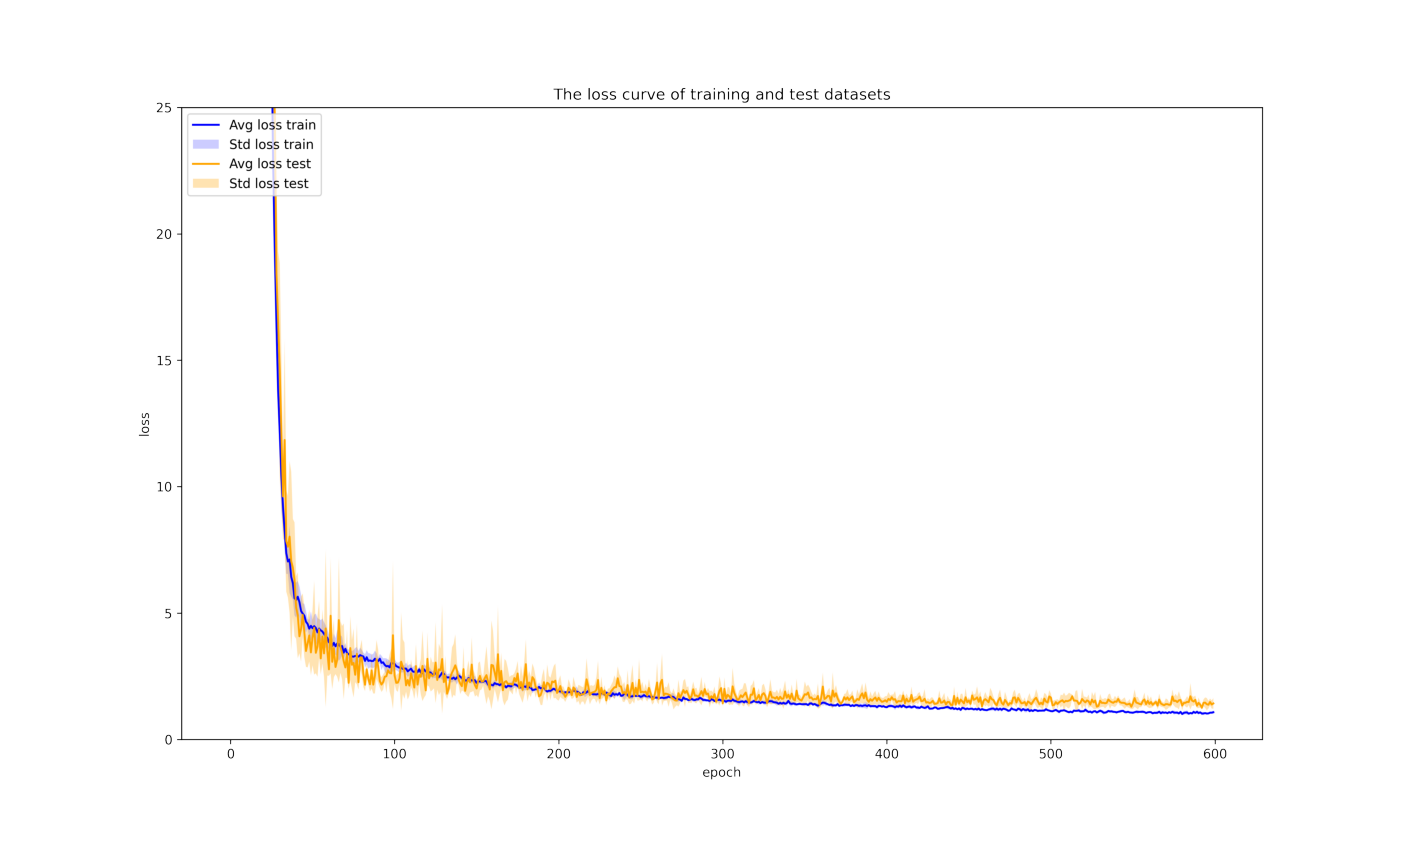

In [44]:
img = mpimg.imread(glob.glob(os.path.join(multirun_dir,'multirun_plot*.png'))[0])
plt.figure(figsize = (25,25))
plt.axis("off")
plt.imshow(img)
plt.show()

## 4.1 Display results of the best run

In [45]:
# Best run weights
multirun_best_weight = mutlirun_instance.mutlirun_table["Weight_file"][0]
multirun_best_dir = mutlirun_instance.mutlirun_table["Run_dir"][0]

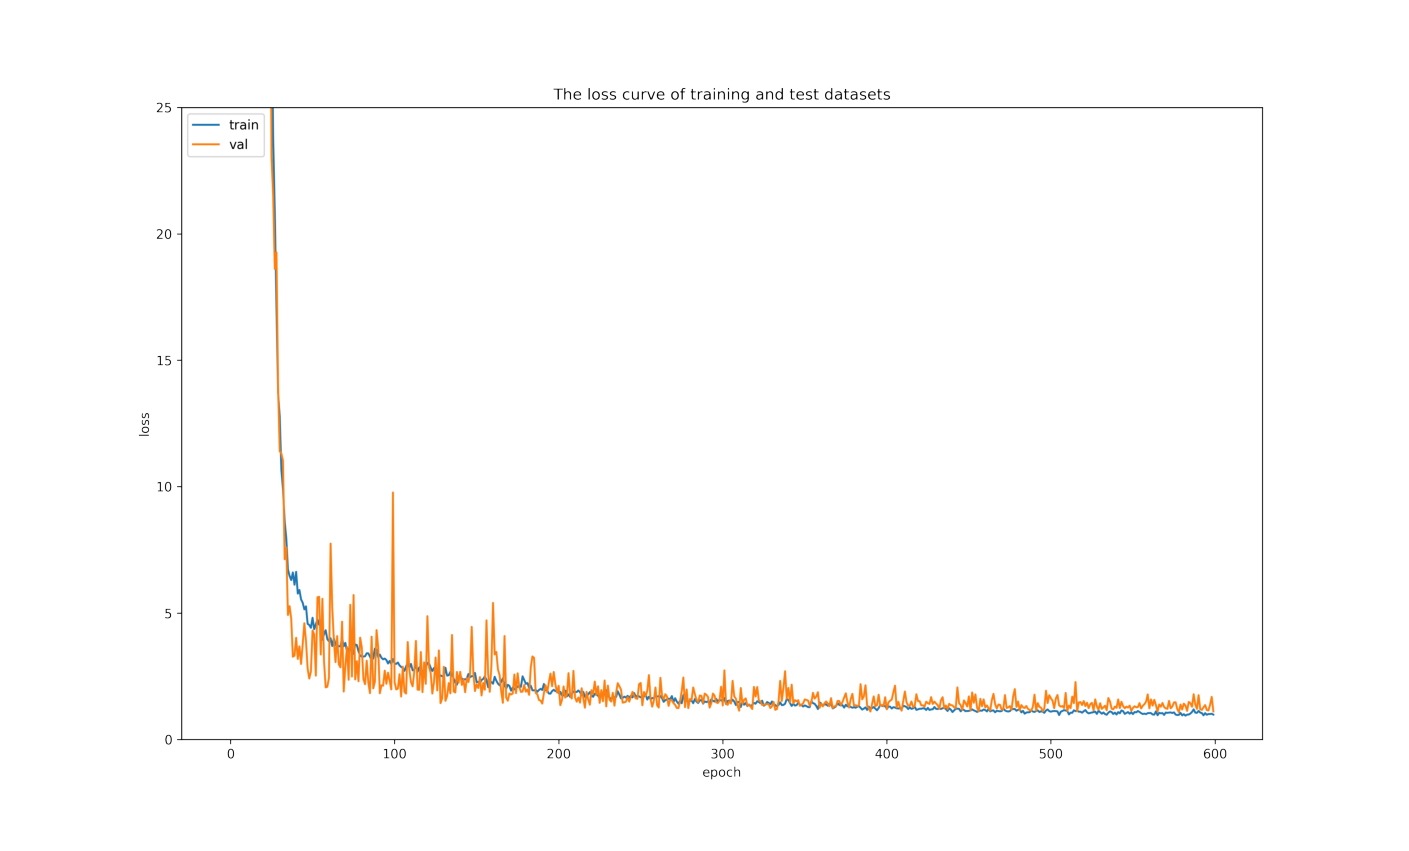

In [46]:
img = mpimg.imread(glob.glob(os.path.join(multirun_best_dir,'Loss_MSE_*.png'))[0])
plt.figure(figsize = (25,25))
plt.axis("off")
plt.imshow(img)
plt.show()

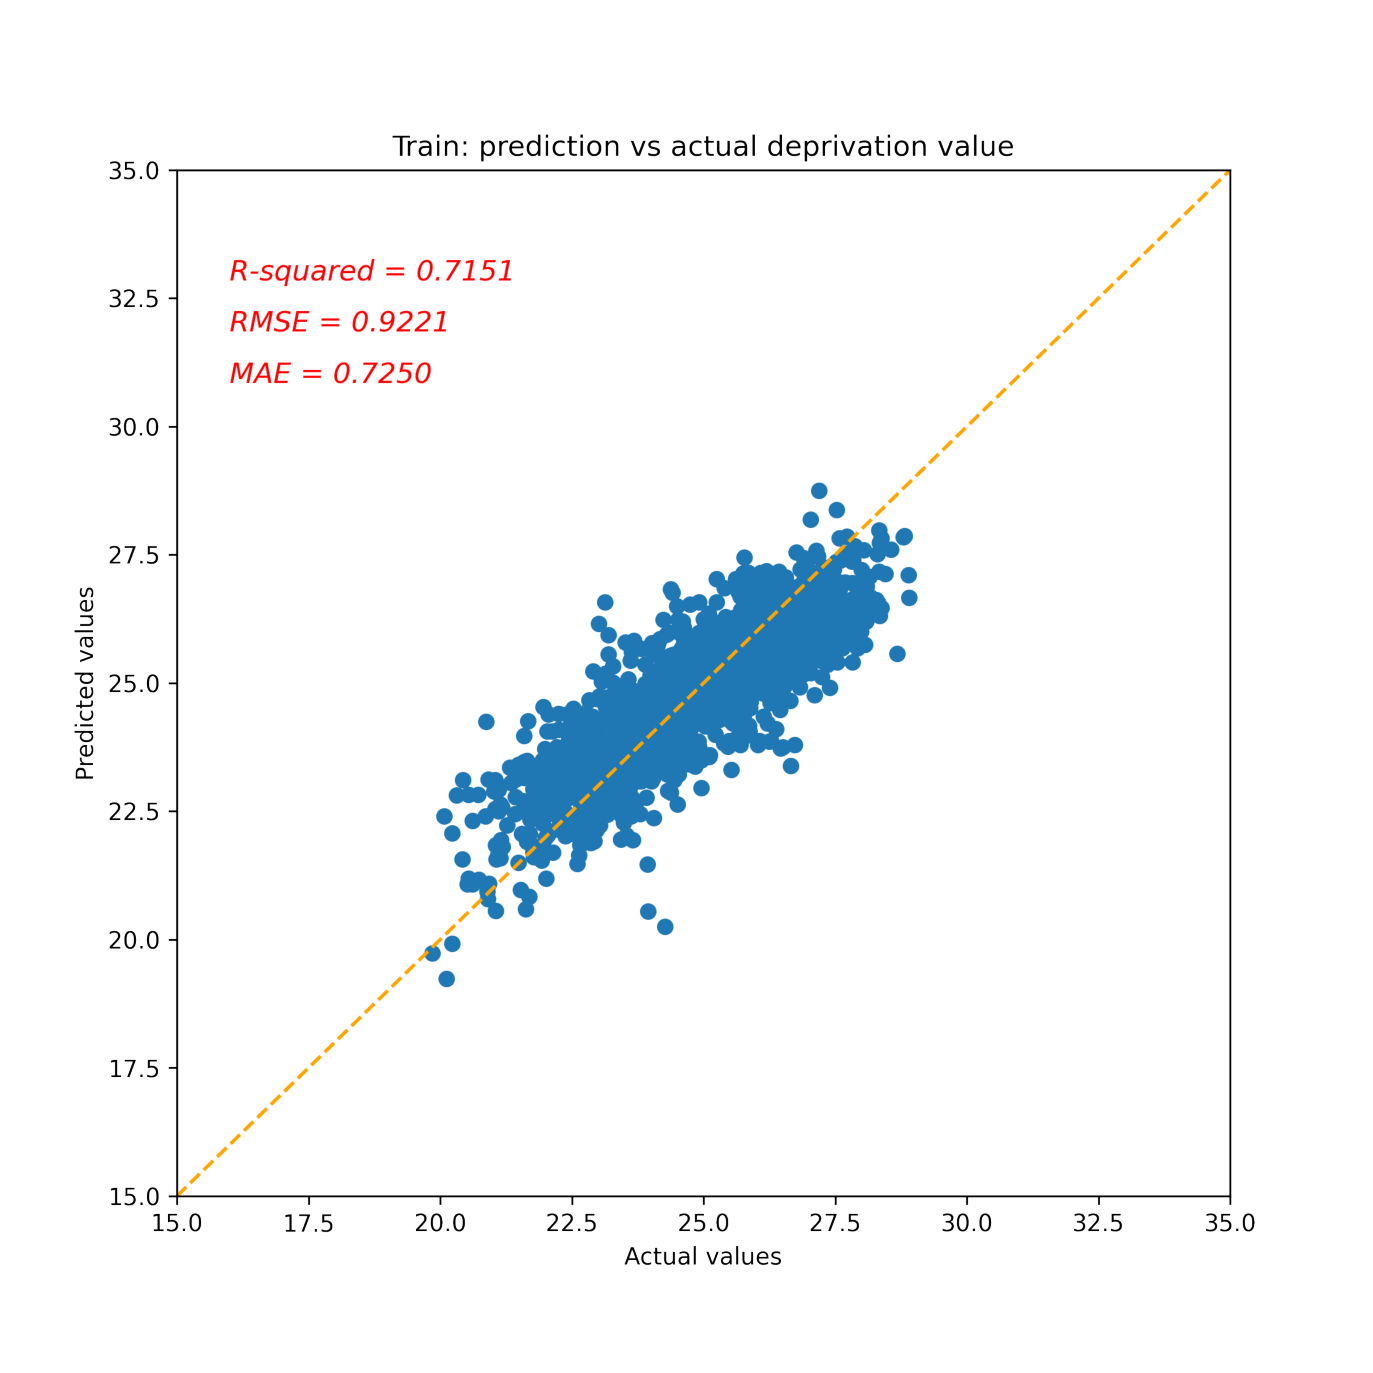

In [47]:
img = mpimg.imread(glob.glob(os.path.join(multirun_best_dir,'mae_train_*.png'))[0])
plt.figure(figsize = (25,25))
plt.axis("off")
plt.imshow(img)
plt.show()

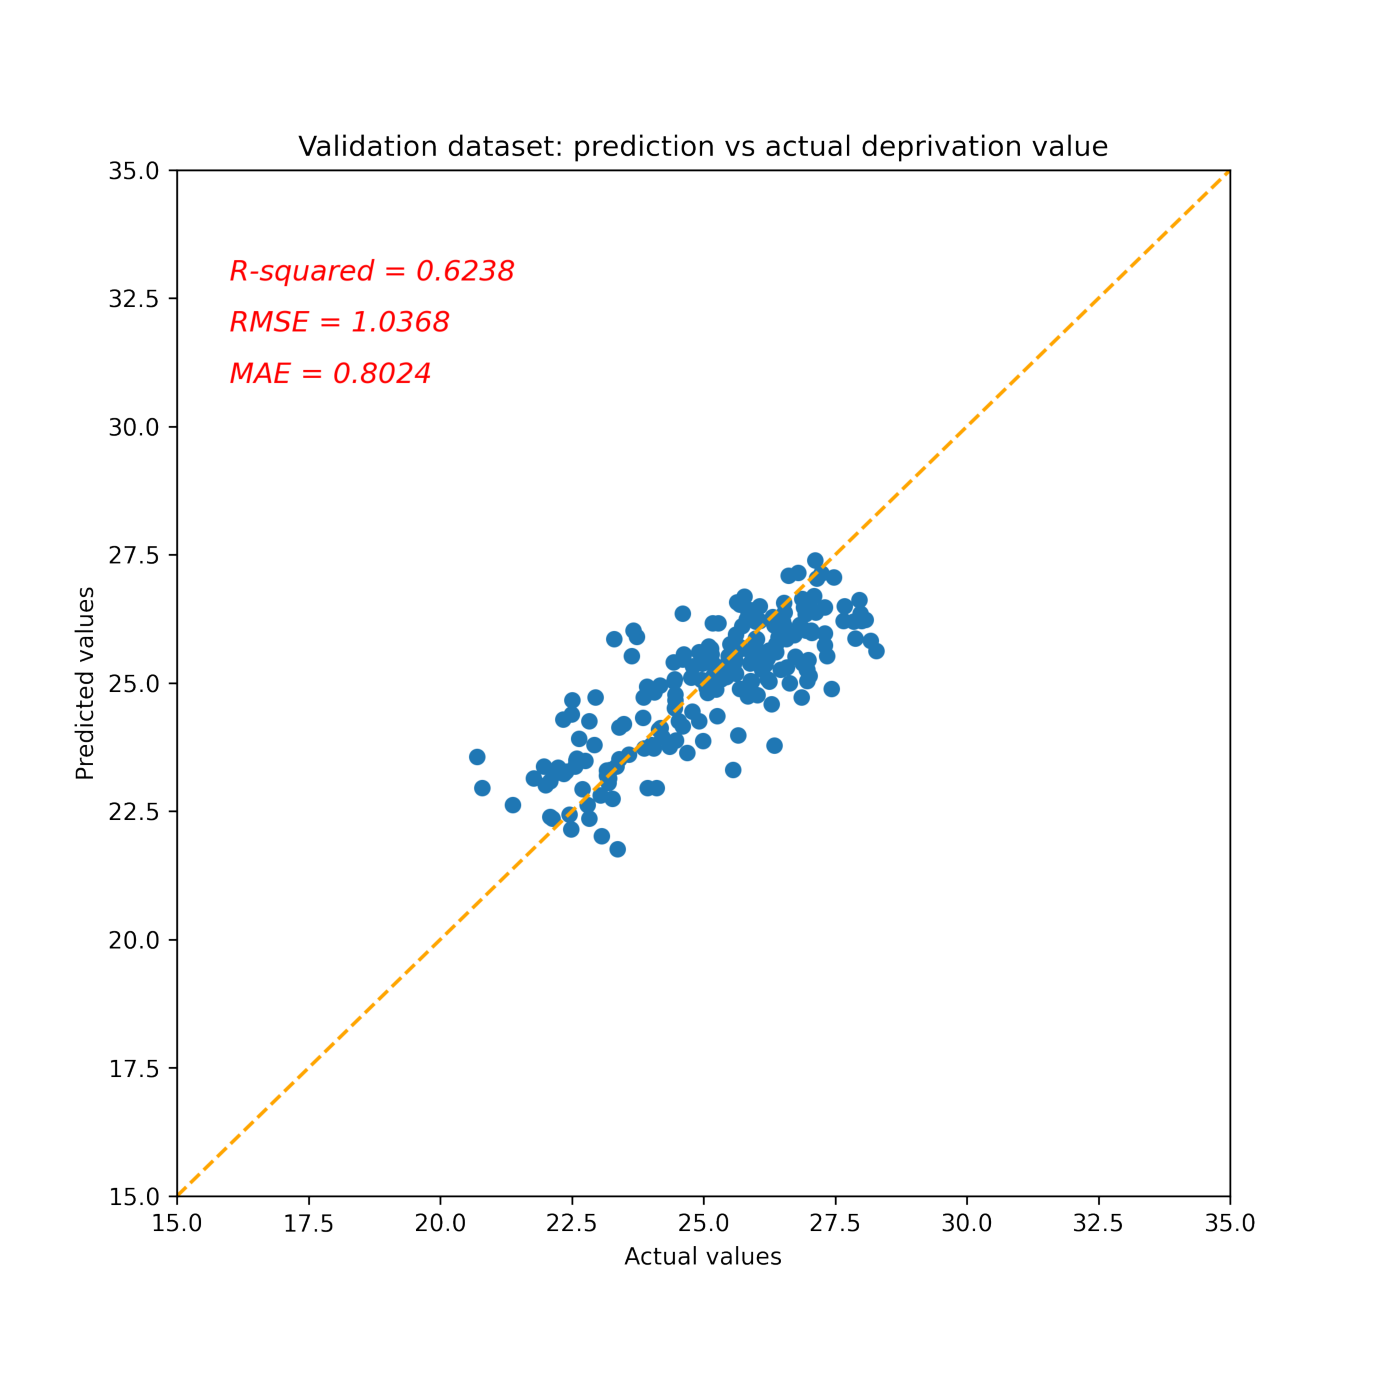

In [48]:
img = mpimg.imread(glob.glob(os.path.join(multirun_best_dir,'mae_test_*.png'))[0])
plt.figure(figsize = (25,25))
plt.axis("off")
plt.imshow(img)
plt.show()

## 4.2 Visualize the best and worse predictions

In [49]:
# Load the predictions of the best run
with h5py.File(glob.glob(os.path.join(multirun_best_dir,'predictions_*.hdf5'))[0], mode="r") as f:
    y_pred_test = np.asarray(f["y_pred_test"])

In [50]:
# Get list of image id and corresponding Absolute Error
pred_val_score = [(x[0],x[1],x[2][0],x[3][0],x[2][0]-x[3][0],np.abs(x[2][0]-x[3][0])) for x in zip(test_ID.tolist(),x_test.tolist(),y_pred_test.tolist(),y_test.tolist())]
pred_val_score = sorted(pred_val_score, key=lambda x: x[5]) #idx0:PartimapID, idx1:Image, idx2:Ypred, idx3:Y, idx4:Error, idx5:AbsError  -- Sort by AbsError 
pred_val_score_bestworse = []
[pred_val_score_bestworse.append(x) for x in pred_val_score[:5]] #Best 
[pred_val_score_bestworse.append(x) for x in pred_val_score[-5:]] #Worse

[None, None, None, None, None]

In [51]:
def Norma_Xpercentile(image_data, prct:int = 2, BGR2RGB=True):
    a = np.ndarray(image_data.shape, dtype='float32')  
    a[:,:,0] = (image_data[:,:,0] - np.nanpercentile(image_data[:,:,0],prct))/(np.nanpercentile(image_data[:,:,0],100-prct) - np.nanpercentile(image_data[:,:,0],prct))
    a[:,:,1] = (image_data[:,:,1] - np.nanpercentile(image_data[:,:,1],prct))/(np.nanpercentile(image_data[:,:,1],100-prct) - np.nanpercentile(image_data[:,:,1],prct))
    a[:,:,2] = (image_data[:,:,2] - np.nanpercentile(image_data[:,:,2],prct))/(np.nanpercentile(image_data[:,:,2],100-prct) - np.nanpercentile(image_data[:,:,2],prct))
    if BGR2RGB: 
        a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    return a

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

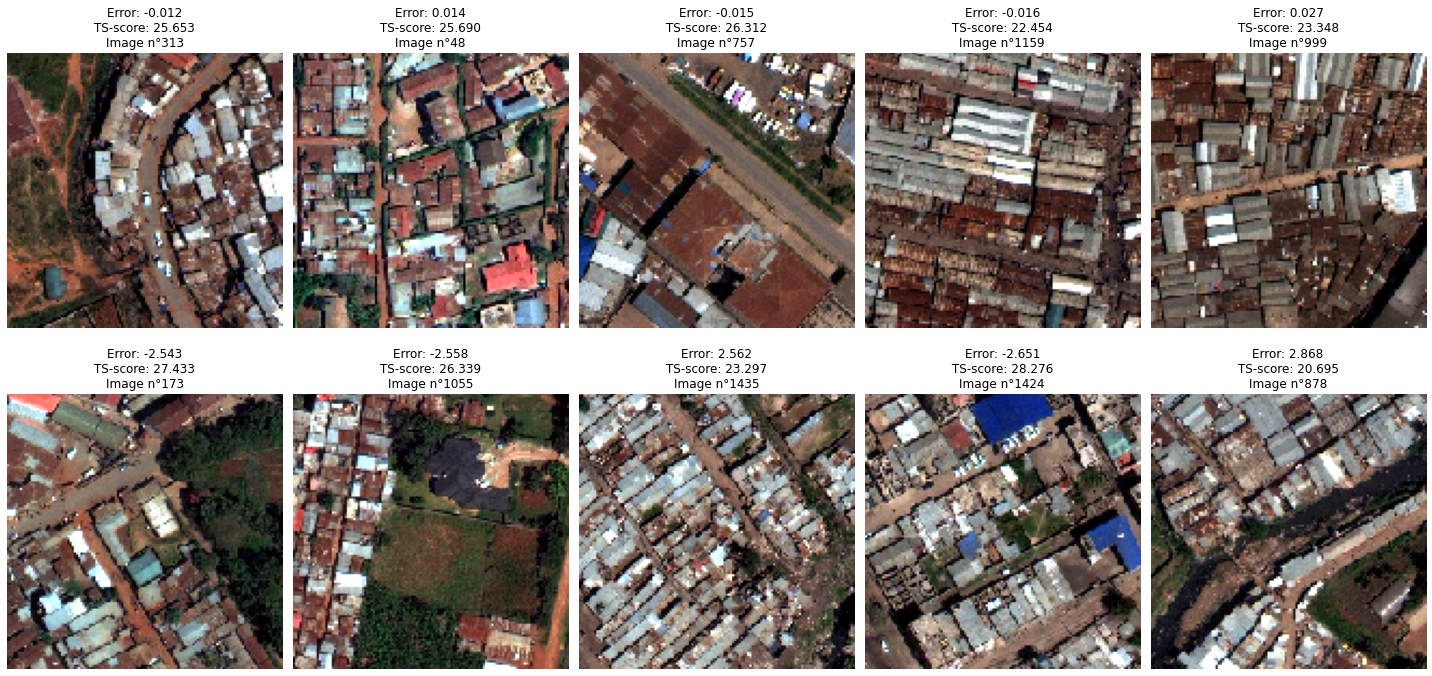

In [52]:
# Visualize the best and worse predictions
plt.rcParams["figure.facecolor"] = 'w'
plt.figure(figsize=(20, 10))
for i in range(len(pred_val_score_bestworse)):
    if i<=4:
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(Norma_Xpercentile(np.array(pred_val_score_bestworse[i][1])))
        plt.axis("off")
        plt.title("Error: %0.3f\n TS-score: %0.3f \nImage n°%s"%(pred_val_score_bestworse[i][4],pred_val_score_bestworse[i][3],pred_val_score_bestworse[i][0]))
    else:
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(Norma_Xpercentile(np.array(pred_val_score_bestworse[i][1])))
        plt.axis("off")
        plt.title("Error: %0.3f\n TS-score: %0.3f \nImage n°%s"%(pred_val_score_bestworse[i][4],pred_val_score_bestworse[i][3],pred_val_score_bestworse[i][0]))
        
#plt.subplots_adjust(hspace=0.001)
plt.tight_layout() 
plt.savefig(os.path.join(results_path,'Best_Worse_Prediction.png'), dpi=300, bbox_inches='tight')